# Applied Machine Learning Homework #3
#### Team: Alexandra Sudomoeva (as5402), Basil Vetas (bsv2111)
#### Date: March 27th, 2019

The overall goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.

### Imports

In [1]:
import os, sys, yaml, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import export_graphviz
from category_encoders import TargetEncoder
from xgboost import XGBClassifier

In [3]:
# custom imports
from utils import load_from_cache, datetime_lookup, save_to_cache, geocoords

### Options

In [4]:
pd.options.display.max_columns = None

sns.set_style("whitegrid")

%matplotlib inline

In [5]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Task 1 Identify Features

Assemble a dataset consisting of features and target (for example in a dataframe or in twoarrays X and y). What features are relevant for the prediction task?What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection.

### Load Data Dictionaries

In [6]:
general_dtypes = yaml.load(open('./yaml/general.yaml'), Loader=yaml.Loader)
general_dates = ['Date_of_Payment', 'Payment_Publication_Date']

research_dtypes = yaml.load(open('./yaml/research.yaml'), Loader=yaml.Loader)
research_dates = ['Date_of_Payment', 'Payment_Publication_Date']

ownership_dtypes = yaml.load(open('./yaml/ownership.yaml'), Loader=yaml.Loader)
ownership_dates = ['Payment_Publication_Date']

### Load Data

File #1 - OP_DTL_GNRL_PGYR2017_P01182019.csv: 
This file contains the data set of General Payments reported for the 2017 program year. General Payments are defined as payments or other transfers of value made to a covered recipient (physician or teaching hospital) that are not made in connection with a research agreement or research protocol. 

In [7]:
try:
    general_df = load_from_cache('./cache/general.pkl', 'general')
except FileNotFoundError as e:
    print(e) # , parse_dates=general_dates
    general_df = pd.read_csv('./data/OP_DTL_GNRL_PGYR2017_P01182019.csv', dtype=general_dtypes)
    save_to_cache('./cache/general.pkl', 'general', general_df)

Loading general data from cache...
Took 13.05 seconds to load general data


File #2 - OP_DTL_RSRCH_PGYR2017_P01182019.csv:
This file contains the data set of Research Payments reported for the 2017 program year. Research Payments are defined as payments or other transfers of value made in connection with a research agreement or research protocol.

In [8]:
try:
    research_df = load_from_cache('./cache/research.pkl', 'research')
except FileNotFoundError as e:
    print(e) #, parse_dates=research_dates
    research_df = pd.read_csv('./data/OP_DTL_RSRCH_PGYR2017_P01182019.csv', dtype=research_dtypes)
    save_to_cache('./cache/research.pkl', 'research', research_df)

Loading research data from cache...
Took 2.19 seconds to load research data


File #3 - OP_DTL_OWNRSHP_PGYR2017_P01182019.csv:
This file contains the data set of Ownership and Investment Interest Information reported for the 2017 program year. Ownership and Investment Interest Information is defined as information on the value of ownership or investment interests that a physician or an immediate family member of a physician held in an applicable manufacturer or applicable group purchasing organization (GPO).  

In [9]:
try:
    ownership_df = load_from_cache('./cache/ownership.pkl', 'ownership')
except FileNotFoundError as e:
    print(e) # , parse_dates=ownership_dates
    ownership_df = pd.read_csv('./data/OP_DTL_OWNRSHP_PGYR2017_P01182019.csv', dtype=ownership_dtypes)
    save_to_cache('./cache/ownership.pkl', 'ownership', ownership_df)

Loading ownership data from cache...
Took 0.01 seconds to load ownership data


In [10]:
general_df.shape

(10663833, 75)

In [11]:
research_df.shape

(602530, 176)

In [12]:
ownership_df.shape

(2630, 29)

Looking at the resulting shapes, the data files appear to be very large in size. Therefore, as suggested by the assgnment guidelines we will be using a subsample in further modeling.

### Build Dataset

Next, we can start building the joined dataset based on the three separate files provided. We will start working with just the two datasets for the baseline. If the need arises, we will be merging the third ownership dataset accordingly.

In [13]:
# keep track of fields by datatype
# this needs to be done before merging (for categoricals) because we lose categorical types on merge
# the others (objects/continuous) are just done here for consistency
gen_obj = (general_df.dtypes == object)
res_obj = (research_df.dtypes == object)
objects = list(set(gen_obj[gen_obj].index.tolist()) & set(res_obj[res_obj].index.tolist()))

gen_cat = (general_df.dtypes == 'category')
res_cat = (research_df.dtypes == 'category')
categoricals = list(set(gen_cat[gen_cat].index.tolist()) & set(res_cat[res_cat].index.tolist()))

gen_cont = (general_df.dtypes == 'float64') | (general_df.dtypes == 'int64')
res_cont = (research_df.dtypes == 'float64') | (research_df.dtypes == 'int64')
continuous = list(set(gen_cont[gen_cont].index.tolist()) & set(res_cont[res_cont].index.tolist()))

In [14]:
# generate target features
# 0: payments not made as part of a research project
# 1: payments made as part of a research project
general_df['Payment_for_Research'] = 0
research_df['Payment_for_Research'] = 1

We inner join on the datasets, taking the intersection of fields and excluding fields that are only in either the research or general datasets, because the presence of values in these fields would inherently leak information about whether the payment was made as part of a research project or not, as it would indirectly indicate which dataset any given observation came from.

In [19]:
df = pd.concat([general_df, research_df], join='inner')

In [21]:
# fix categorical types that were lost
for col in categoricals:
    if df[col].dtype.name != 'category':
        df[col] = df[col].astype('category')

In [23]:
# sanity check - should print True
cat = (df.dtypes == 'category')
set(cat[cat].index.tolist()) == set(categoricals)

True

In [24]:
# sanity check - should print True
intersection = list(set(general_df.columns) & set(research_df.columns))
set(df.columns) == set(intersection) == set(objects + categoricals + continuous + ['Payment_for_Research'])

True

We drop fields that have a single unique value, or that have all different values, as these won't be informative for a model

In [25]:
# fields with a single unique value
single = (df.nunique() == 1)
single_val = single[single].index.tolist()

# fields with all different values
diff = (df.nunique() == df.shape[0])
diff_vals = diff[diff].index.tolist()

df.drop(columns=single_val + diff_vals, inplace=True)

# update our lists
objects = list(set(objects) - set(single_val + diff_vals))
categoricals = list(set(categoricals) - set(single_val + diff_vals))
continuous = list(set(continuous) - set(single_val + diff_vals))

In [26]:
# we are now left with 61 features in total
df.shape

(11266363, 61)

In [27]:
# looking at the sample of the resulting joined dataframe
df.sample(5)

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Recipient_Province,Recipient_Postal_Code,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,Physician_License_State_code4,Physician_License_State_code5,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Form_of_Payment_or_Transfer_of_Value,Dispute_Status_for_Publication,Related_Product_Indicator,Covered_or_Noncovered_Indicator_1,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Product_Category_or_Therapeutic_Area_1,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Associated_Drug_or_Biological_NDC_1,Covered_or_Noncovered_Indicator_2,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2,Product_Category_or_Therapeutic_Area_2,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Associated_Drug_or_Biological_NDC_2,Covered_or_Noncovered_Indicator_3,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3,Product_Category_or_Therapeutic_Area_3,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3,Associated_Drug_or_Biological_NDC_3,Covered_or_Noncovered_Indicator_4,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Payment_for_Research
8113555,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,772955,ANITA,NaN,CHANDRA PURI,NaN,1460 N HALSTED SUITE 505,NaN,CHICAGO,IL,60642,United States,NaN,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Pediatrics,IL,NaN,NaN,NaN,NaN,Pfizer Inc.,100000000286,PFIZER INC.,NY,United States,24.00,02/28/2017,In-kind items and services,No,Yes,Covered,Drug,NEUROSCIENCE,QUILLIVANT XR,24478-190-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6650208,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,345359,MARK,NaN,GIBBS,NaN,1625 N GRAND AVE,NaN,GAINESVILLE,TX,76240,United States,NaN,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,TX,NaN,NaN,NaN,NaN,Allergan Inc.,100000000278,Allergan Inc.,NJ,United States,10.87,06/02/2017,In-kind items and services,No,Yes,Covered,Drug,NEUROSCIENCE,NAMZARIC,0456-1214-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1586337,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,360461,JANG,BOO,CHI,NaN,143 NORTH ST,NaN,AUBURN,NY,13021,United States,NaN,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,NY,NaN,NaN,NaN,NaN,Valeant Pharmaceuticals International,100000010935,Valeant Pharmaceuticals North America LLC,NJ,United States,9.29,10/24/2017,In-kind items and services,No,Yes,Covered,Drug,GASTROENTEROLOGY,RELISTOR ORAL,65649-551-03,Covered,Drug,GASTROENTEROLOGY,XIFAXANIBSD,65649-303-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3697234,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,305700,PAUL,NaN,SUTERA,NaN,2767 SILVER CREEK RD,STE A,BULLHEAD CITY,AZ,86442,United States,NaN,NaN,Medical Doctor,Allopathic & Osteopathic Physicians|Anesthesio...,AZ,NaN,NaN,NaN,NaN,Abbott Laboratories,100000010680,Abbott Laboratories,

Looking at the resulting dataframe, there seems to be quite a lot of missing values that need to be dealt with before we proceed into baseline modeling.

### Missing Data

Let's get fields where more than 75% of values are null. We'll inspect these fields to see if it seems safe to drop them. Most likely they will not be informative if the missing values counts are so high.

In [28]:
null_msk = df.isna().sum() / df.shape[0] > .75
nulls_over_75pct = null_msk[null_msk].index.tolist()

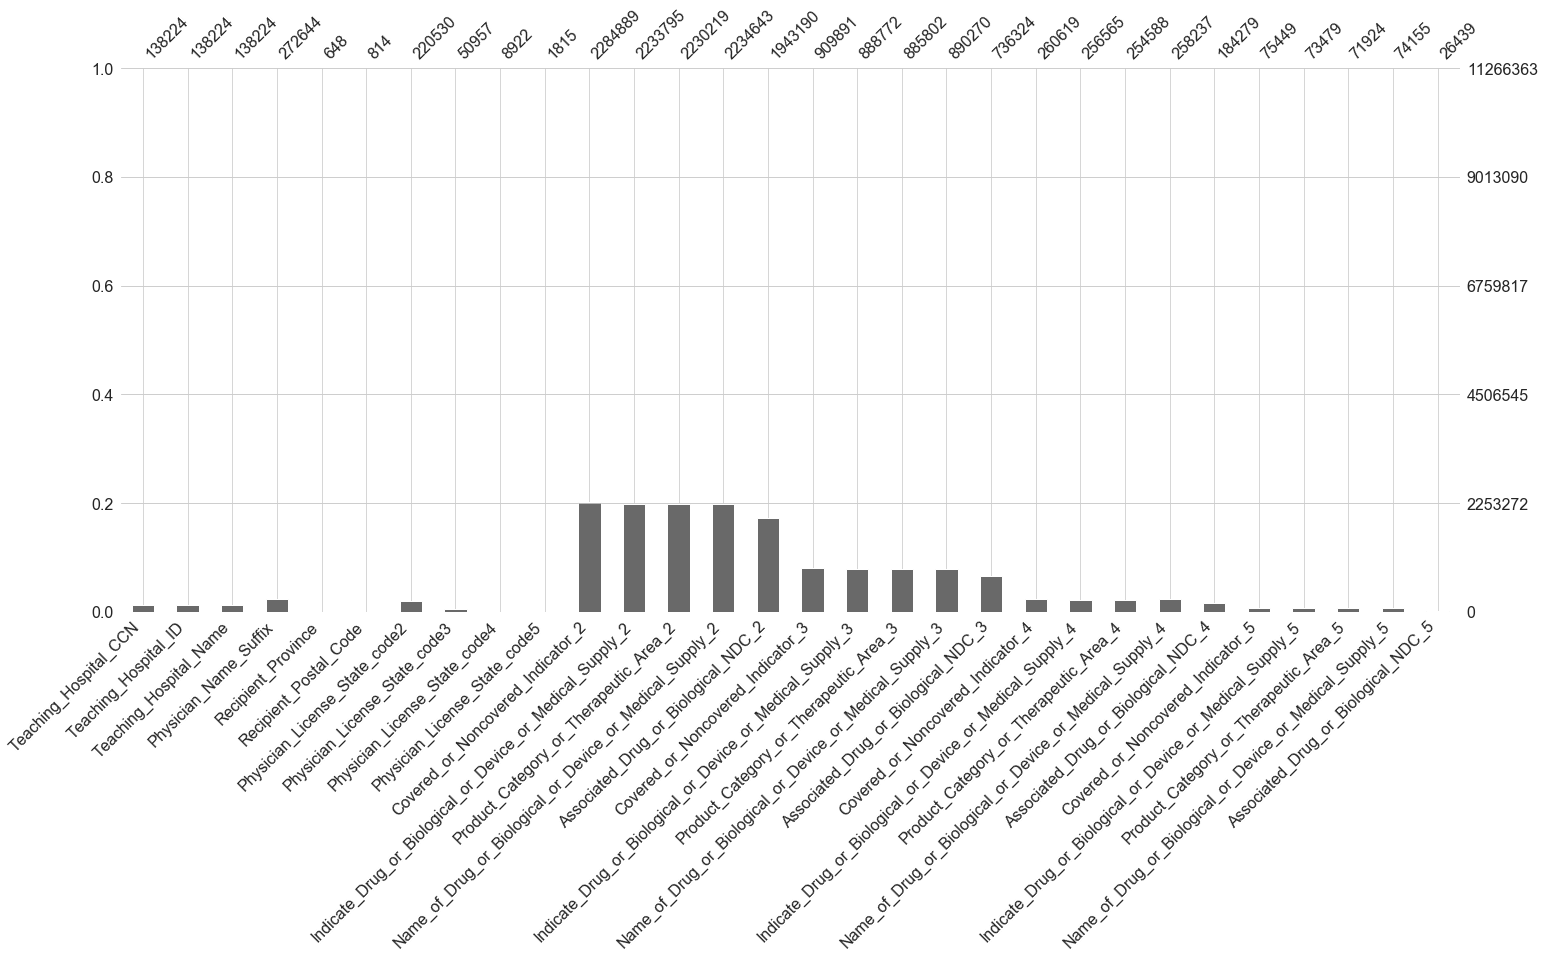

In [29]:
msno.bar(df[nulls_over_75pct])

In [30]:
df[nulls_over_75pct].dtypes

Teaching_Hospital_CCN                                        category
Teaching_Hospital_ID                                         category
Teaching_Hospital_Name                                         object
Physician_Name_Suffix                                          object
Recipient_Province                                           category
Recipient_Postal_Code                                        category
Physician_License_State_code2                                category
Physician_License_State_code3                                category
Physician_License_State_code4                                category
Physician_License_State_code5                                category
Covered_or_Noncovered_Indicator_2                            category
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2    category
Product_Category_or_Therapeutic_Area_2                       category
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2     category
Associated_Drug_or_B

None of these fields seem too important so we will drop them.

In [31]:
df.drop(columns=nulls_over_75pct, inplace=True)

# update our lists
objects = list(set(objects) - set(nulls_over_75pct))
categoricals = list(set(categoricals) - set(nulls_over_75pct))
continuous = list(set(continuous) - set(nulls_over_75pct))

In [32]:
# sanity check - should print True
set(df.columns) == set(objects + categoricals + continuous + ['Payment_for_Research'])

True

Let's see if any of the remaining fields have patterns when plotted by the target feature classes. If so, that likely means there is information leak and we will drop these.

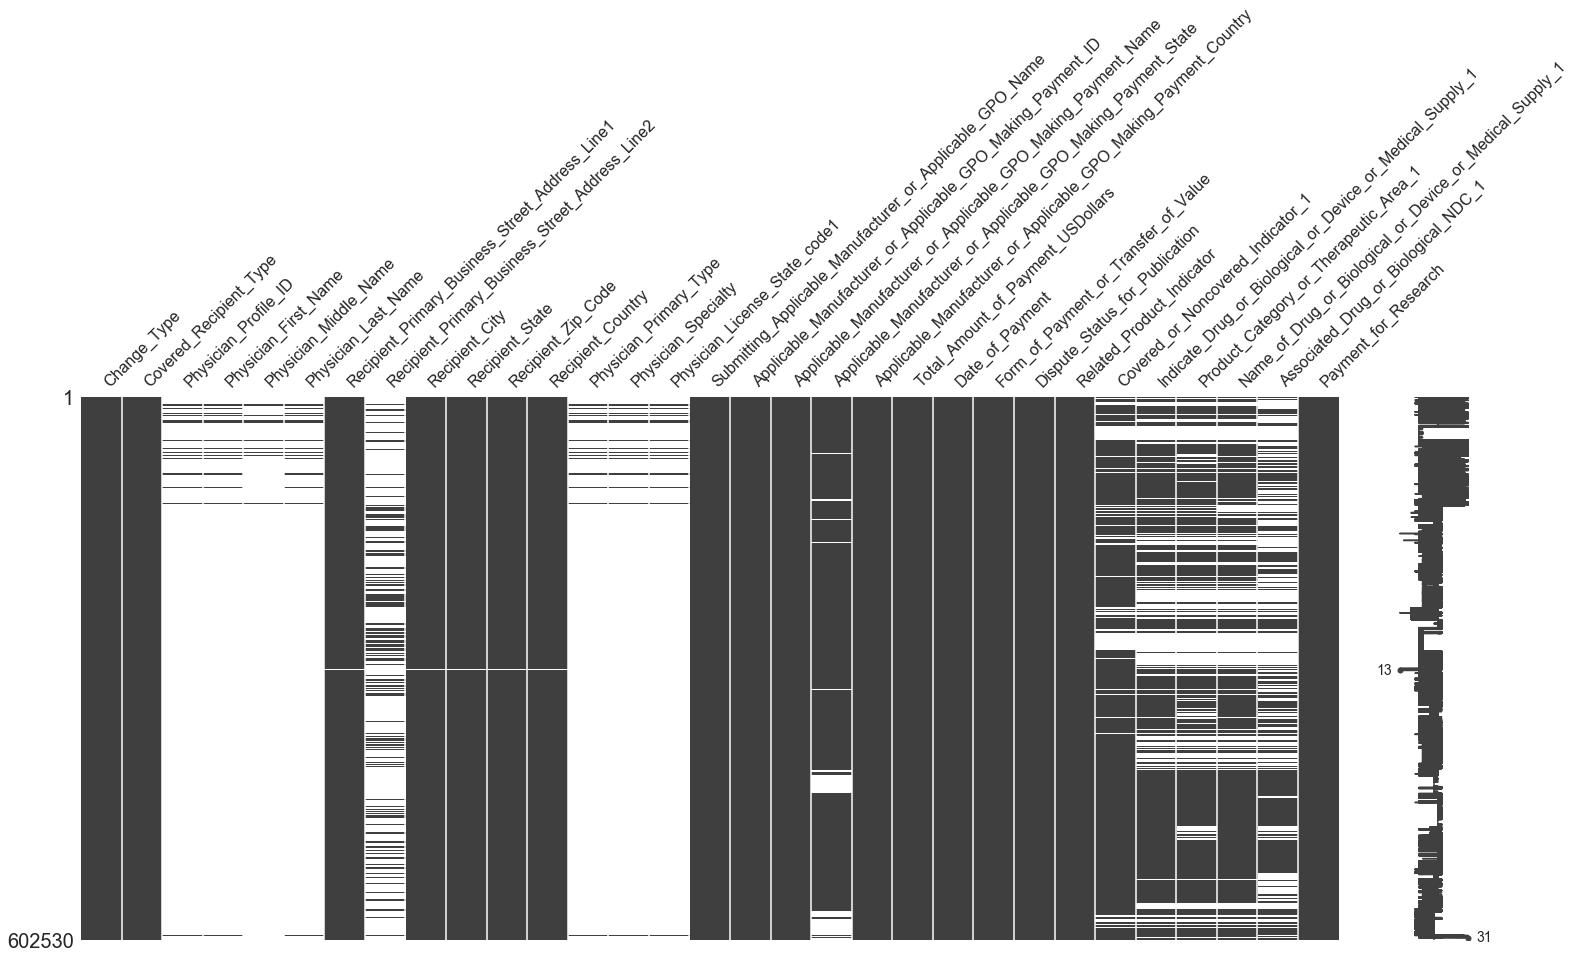

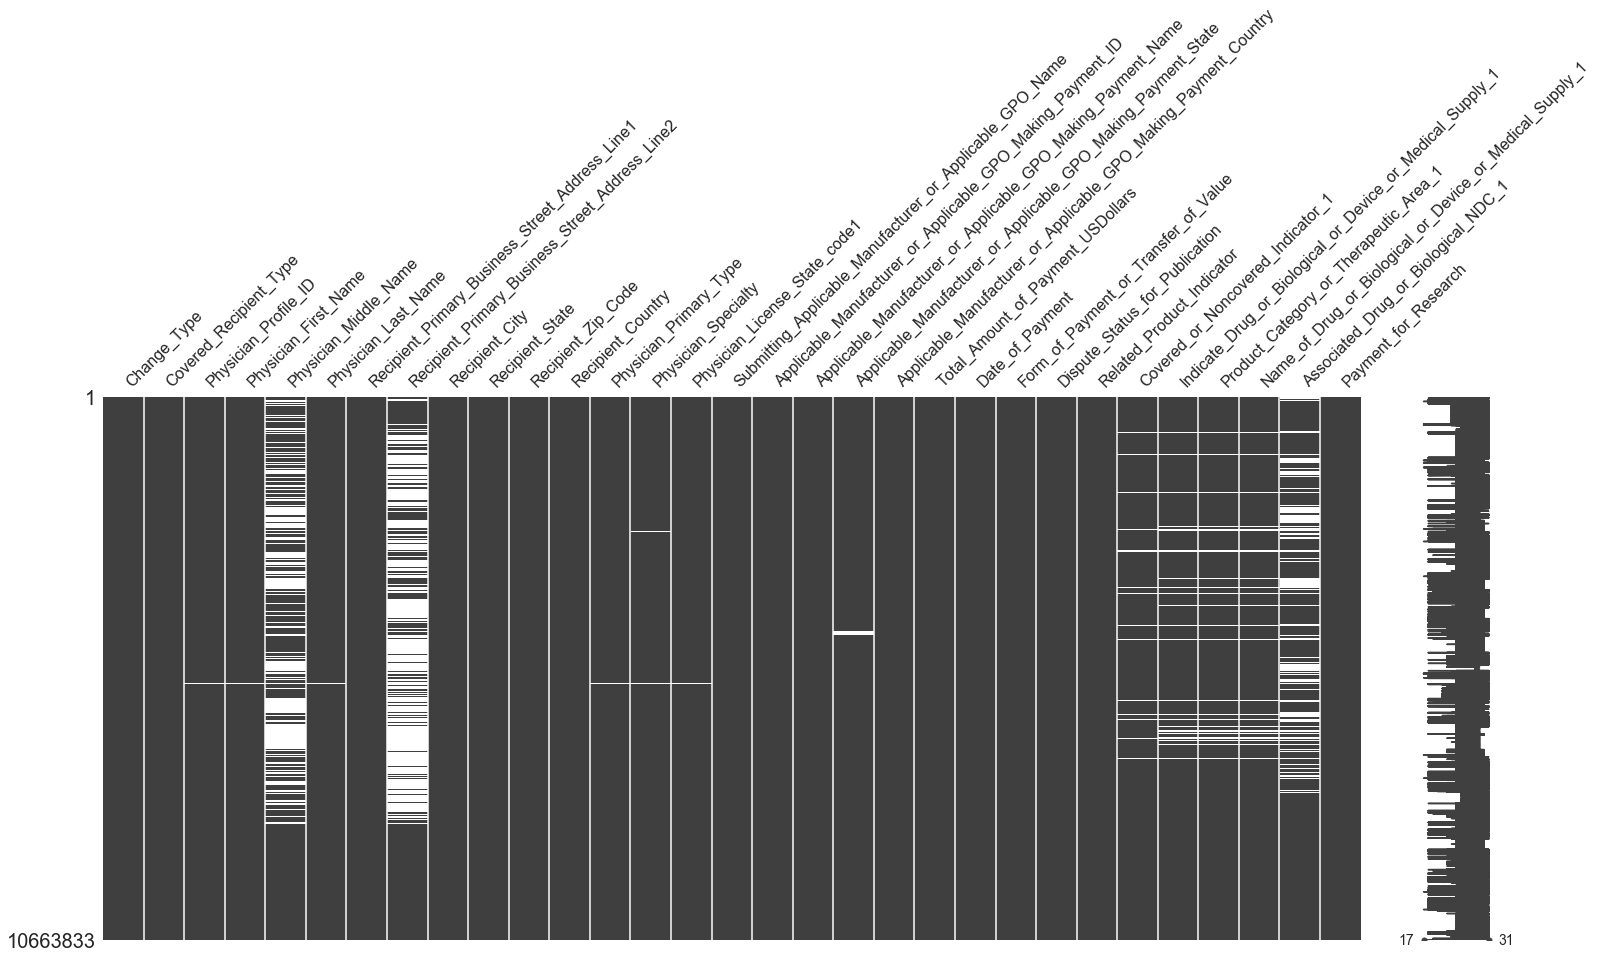

In [33]:
msno.matrix(df[df['Payment_for_Research'] == 1])
msno.matrix(df[df['Payment_for_Research'] == 0])

All the physician specific fields appear largely missing for the research class and present for the general class. Namely, physician first, middle and last name, ID, primary type, specialty and license code.  We will drop these to prevent information leak. There also seems to be a reasonable amount of discrepancy in missing values between the two target classes for the last five fields subscripted by "\_1" therefore to be on the safe side we'll drop these fields as well to prevent information leak.

In [34]:
physician_cols = df.filter(regex='Physician_').columns.tolist()
subscripted_cols = df.filter(regex='_1').columns.tolist()
df.drop(columns=physician_cols + subscripted_cols, inplace=True)

# update our lists
objects = list(set(objects) - set(physician_cols + subscripted_cols))
categoricals = list(set(categoricals) - set(physician_cols + subscripted_cols))
continuous = list(set(continuous) - set(physician_cols + subscripted_cols))

In [35]:
# sanity check - should print True
set(df.columns) == set(objects + categoricals + continuous + ['Payment_for_Research'])

True

A quick look at our remaining fields

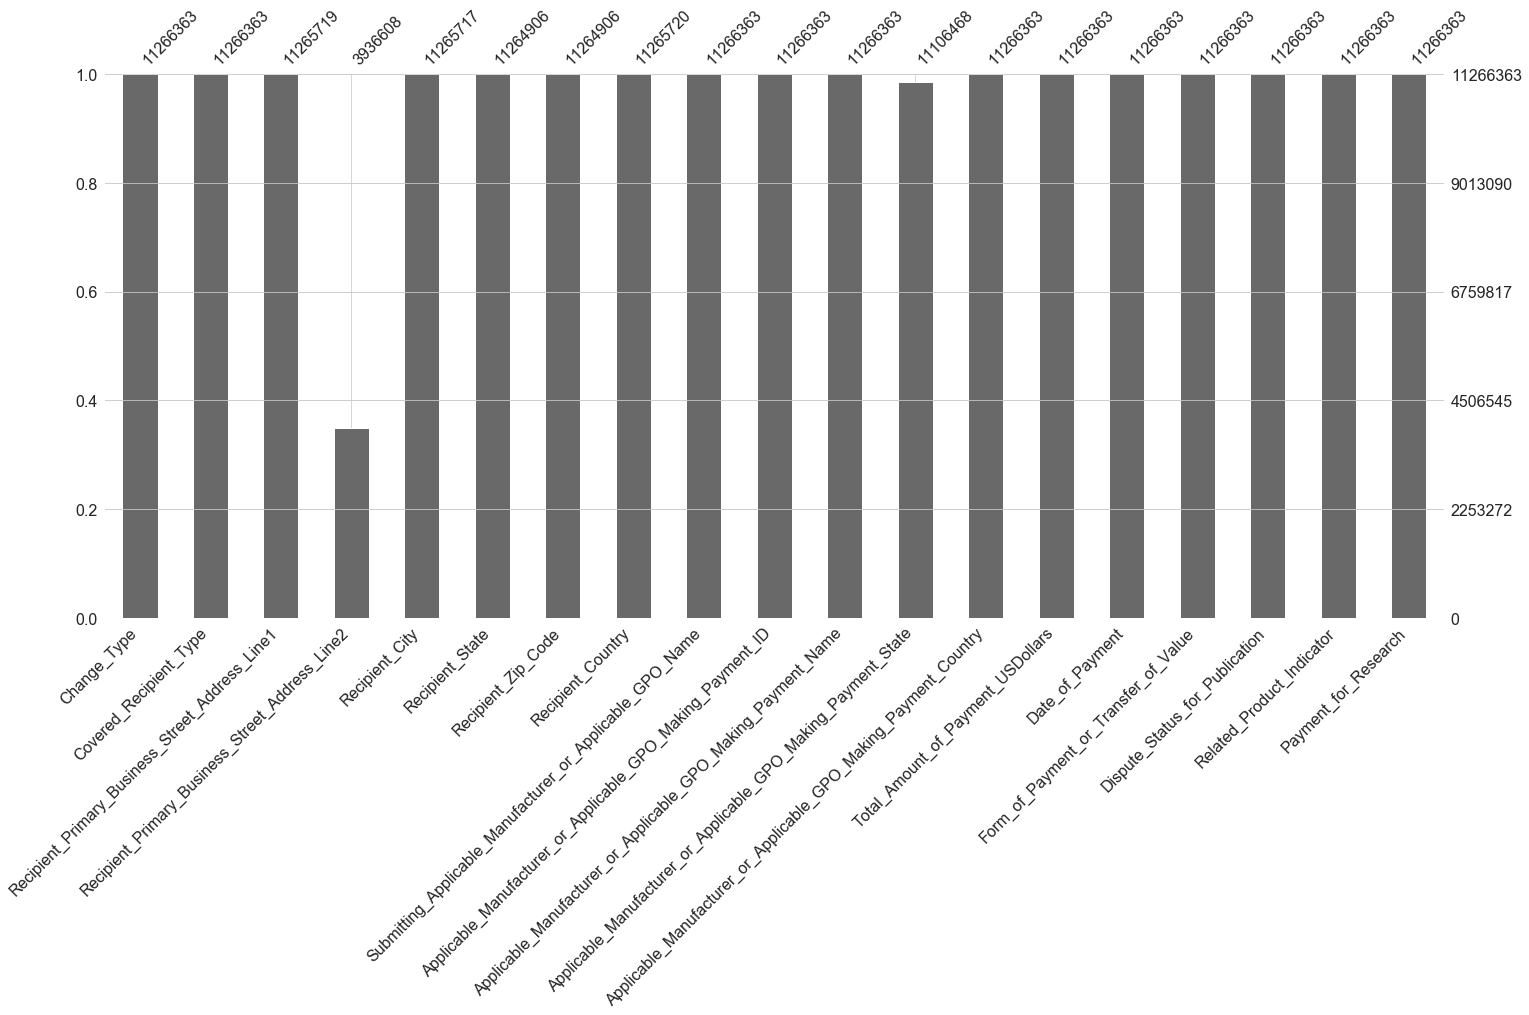

In [36]:
msno.bar(df)

### Clean Data

In [37]:
df.sample(5)

,Change_Type,Covered_Recipient_Type,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Form_of_Payment_or_Transfer_of_Value,Dispute_Status_for_Publication,Related_Product_Indicator,Payment_for_Research
4270673,UNCHANGED,Covered Recipient Physician,2100 Jane St Ste 201,NaN,Pittsburgh,PA,15203,United States,"Boehringer Ingelheim Pharmaceuticals, Inc.",100000000234,"Boehringer Ingelheim Pharmaceuticals, Inc.",CT,United States,15.07,12/11/2017,In-kind items and services,No,Yes,0
2646979,UNCHANGED,Covered Recipient Physician,925 CLIFTON AVE,NaN,CLIFTON,NJ,07013,United States,Gilead Sciences Inc,100000000108,Gilead Sciences Inc,CA,United States,17.72,11/01/2017,In-kind items and services,No,Yes,0
2303913,UNCHANGED,Covered Recipient Physician,202 ROCK CREEK PARKWAY,NaN,FAIRHOPE,AL,36532-3349,United States,Sandoz Inc.,100000000062,Sandoz Inc.,NJ,United States,13.58,01/12/2017,In-kind items and services,No,Yes,0
6832646,UNCHANGED,Covered Recipient Physician,1031 MCBRIDE AVE,NaN,WOODLAND PARK,NJ,07424-2559,United States,Allergan Inc.,100000000278,Allergan Inc.,NJ,United States,12.03,04/03/2017,In-kind items and services,No,No,0
701636,UNCHANGED,Covered Recipient Physician,1514 JEFFERSON HWY,NaN,NEW ORLEANS,LA,70121-2429,United States,"Biosense Webster, Inc.",100000005693,"Biosense Webster, Inc.",CA,United States,13.27,08/15/2017,In-kind items and services,No,Yes,0


Some simple data cleaning on a few of our remaining fields. These are just based on visual inspection of the sample above. Hopefully this helps consolidate a few categories on the newly cleaned categorial columns.

In [38]:
# fixes title that are all uppercase
title_cols = [
    'Recipient_Primary_Business_Street_Address_Line1',
    'Recipient_Primary_Business_Street_Address_Line2',
    'Recipient_City'
]

for col in title_cols:
    df[col] = df[col].apply(lambda x: x.title() if type(x) != float else x)

# removes extra extension from zip codes when present
zip_cols = [
    'Recipient_Zip_Code'
]

for col in zip_cols:
    df[col] = df[col].apply(lambda x: x.split('-')[0] if type(x) != float else x)

In [39]:
# fix categorical types that were lost
for col in categoricals:
    if df[col].dtype.name != 'category':
        df[col] = df[col].astype('category')

### Explore Data

First let's take a look at the text features and see if it seems like we can use them 

In [40]:
df[objects].sample(5)

,Recipient_Primary_Business_Street_Address_Line1,Date_of_Payment,Recipient_Primary_Business_Street_Address_Line2
8922616,25 Michigan St Ne,04/03/2017,Suite 6100
3406755,1050 W 10Th St,11/09/2017,NaN
2483505,5800 Coit Rd Ste 100,08/17/2017,NaN
6308769,2000A Southbridge Pkwy,04/19/2017,Ste 300
82950,1500 East Duarte Road,04/25/2017,NaN


In [41]:
df[objects].nunique()

Recipient_Primary_Business_Street_Address_Line1    508109
Date_of_Payment                                       365
Recipient_Primary_Business_Street_Address_Line2     83893
dtype: int64

Next let's look at the categorical features

In [42]:
df[categoricals].sample(5)

,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Form_of_Payment_or_Transfer_of_Value,Recipient_Country,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Change_Type,Related_Product_Indicator,Recipient_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Dispute_Status_for_Publication,Recipient_Zip_Code,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Covered_Recipient_Type,Recipient_City,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name
4628981,100000131389,Cash or cash equivalent,United States,Horizon Pharma plc,UNCHANGED,Yes,NY,Ireland,No,10021,NaN,Covered Recipient Physician,New York,Horizon Pharma plc
443323,100000076361,Cash or cash equivalent,United States,"Ocular Therapeutix, Inc.",UNCHANGED,Yes,CA,United States,No,63131,MA,Non-covered Recipient Entity,Artesia,"Ocular Therapeutix, Inc."
289509,100000000146,In-kind items and services,United States,AstraZeneca Pharmaceuticals LP,UNCHANGED,Yes,NC,United States,No,28275,DE,Covered Recipient Physician,Charlotte,AstraZeneca Pharmaceuticals LP
9863746,100000005372,Cash or cash equivalent,United States,"AtriCure, Inc.",UNCHANGED,Yes,NC,United States,No,28803,OH,Covered Recipient Physician,Asheville,"AtriCure, Inc."
3508097,100000005432,Cash or cash equivalent,United States,Purdue Pharma L.P.,UNCHANGED,Yes,PA,United States,No,19104,CT,Covered Recipient Physician,Philadelphia,Purdue Pharma L.P.


In [43]:
df[categoricals].nunique()

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID          1495
Form_of_Payment_or_Transfer_of_Value                                    6
Recipient_Country                                                      25
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name        1529
Change_Type                                                             3
Related_Product_Indicator                                               2
Recipient_State                                                        61
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country       41
Dispute_Status_for_Publication                                          2
Recipient_Zip_Code                                                  20628
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State         48
Covered_Recipient_Type                                                  4
Recipient_City                                                      12912
Submitting_Applicable_Manufacturer_or_

Lastly we look at the continuous features

In [44]:
df[continuous].sample(5)

,Total_Amount_of_Payment_USDollars
8210898,16.25
9150713,300.00
206366,465.30
9533414,28.58
5968555,2.54


In [45]:
df[continuous].nunique()

Total_Amount_of_Payment_USDollars    220159
dtype: int64

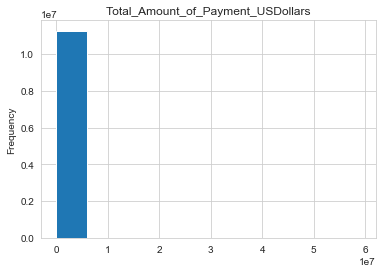

In [46]:
for col in continuous:
    df[col].plot(kind='hist', title=col)
    plt.show()

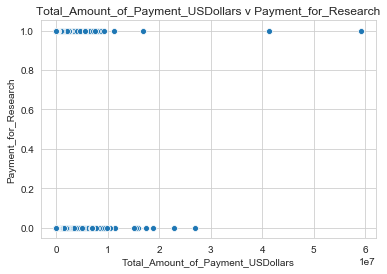

In [47]:
for col in continuous:
    sns.scatterplot(x=df[col], y=df['Payment_for_Research'])
    plt.title(f'{col} v Payment_for_Research')
    plt.show()

We probably won't use the text features for our baseline model, but may be able to engineer additional features from them later on.  Many of our categorical features have high cardinality and will have to be dealt with so that we don't blow up the dimensionality of our model. We only have a single continuous numeric feature, however it is interesting that it only has ~200k unique values (for over 10m observations). It also looks like we'll need to scale the continuous field as there appears to be some skew/outliers. Finally, notice that the classes of our target feature are heavily imbalanced. We'll need to handle this later on.

In [48]:
df[df['Payment_for_Research'] == 1].shape[0]/df.shape[0]

0.05348043552298111

In [49]:
df[df['Payment_for_Research'] == 0].shape[0]/df.shape[0]

0.9465195644770189

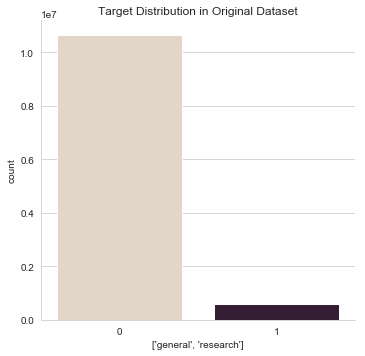

In [50]:
# visualizing class imbalance of target feature
sns.catplot(x='Payment_for_Research', kind='count', palette="ch:.25", data=df)
plt.xlabel(['general', 'research'])
plt.title('Target Distribution in Original Dataset')
plt.show()

After some iteration in Task 2, we discovered one remaining feature that was leaking information about the target feature: `Covered_Recipient_Type`.  This was discovered by running a linear model on individual features one at a time, and found one feature that predicted ~97% correctly on its own.  After some inspection, we see below that for the general payments this field contains only two categories but for the research payments it contains four, so those extra two categories in this field strongly leak information about the target feature. Thus we will drop it here.

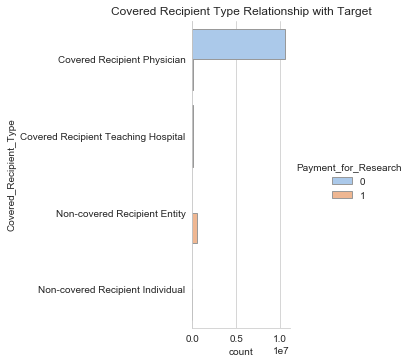

In [51]:
# a bar chart visualization of the problem stated above
sns.catplot(y="Covered_Recipient_Type", hue="Payment_for_Research", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)
plt.title('Covered Recipient Type Relationship with Target')
plt.show()

In [52]:
general_df['Covered_Recipient_Type'].value_counts()

Covered Recipient Physician            10622090
Covered Recipient Teaching Hospital       41743
Name: Covered_Recipient_Type, dtype: int64

In [53]:
research_df['Covered_Recipient_Type'].value_counts()

Non-covered Recipient Entity           480591
Covered Recipient Teaching Hospital     96481
Covered Recipient Physician             24815
Non-covered Recipient Individual          643
Name: Covered_Recipient_Type, dtype: int64

In [54]:
df.drop(columns=['Covered_Recipient_Type'], inplace=True)

# update list
categoricals = list(set(categoricals) - set(['Covered_Recipient_Type']))

In [55]:
# sanity check - should print True
set(df.columns) == set(objects + categoricals + continuous + ['Payment_for_Research'])

True

We cache our dataframe to finish task 1.

In [56]:
df.reset_index(drop=True, inplace=True)
save_to_cache('./cache/task1.pkl', 'task1', df)

Caching task1 data...
Took 9.03 seconds to cache task1


## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset.


In [29]:
try:
    df2 = load_from_cache('./cache/task1.pkl', 'task1')
    
    # rebuild our column lists if we load from cache
    obj_msk = (df2.dtypes == object)
    cat_msk = (df2.dtypes == 'category')
    cont_msk = (df2.dtypes == 'float64') | (df2.dtypes == 'int64')
    objects = obj_msk[obj_msk].index.tolist()
    categoricals = cat_msk[cat_msk].index.tolist()
    continuous = list(set(cont_msk[cont_msk].index.tolist()) - set(['Payment_for_Research']))
except FileNotFoundError as e:
    print(e)
    df2 = df

Loading task1 data from cache...
Took 3.51 seconds to load task1 data


### Preprocessing

Let's subsample the data, both for convenience and as an initial way to deal with the imbalanced classes. We have enough observations in each class to still build a robust model despite generously subsampling the data.

In [30]:
pos_class = df2[df2['Payment_for_Research'] == 1].sample(n=10000, random_state=42)
neg_class = df2[df2['Payment_for_Research'] == 0].sample(n=10000, random_state=42)
df2 = pd.concat([pos_class, neg_class])

For the baseline model we'll just drop the object/text features 

In [31]:
df2.drop(columns=objects, inplace=True)

In [32]:
# we are now left with only 15 features
df2.shape

(20000, 15)

For the baseline model, we'll just drop the high cardinality categorical features, specifically, we'll drop any categorical with more than 10 categories

In [33]:
X = df2.drop(columns=['Payment_for_Research'])
y = df2['Payment_for_Research']

In [34]:
X[categoricals].nunique()

Change_Type                                                            3
Recipient_City                                                      2568
Recipient_State                                                       53
Recipient_Zip_Code                                                  4960
Recipient_Country                                                      3
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name            508
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID          571
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name        582
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State        37
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country      17
Form_of_Payment_or_Transfer_of_Value                                   2
Dispute_Status_for_Publication                                         2
Related_Product_Indicator                                              2
dtype: int64

In [35]:
drop_msk = (X[categoricals].nunique() > 10)
ohe_msk = ~drop_msk

drop_cols = drop_msk[drop_msk].index.tolist()
ohe_cols = ohe_msk[ohe_msk].index.tolist()

In [36]:
X.drop(columns=drop_cols, inplace=True)

In [37]:
X[ohe_cols].nunique()

Change_Type                             3
Recipient_Country                       3
Form_of_Payment_or_Transfer_of_Value    2
Dispute_Status_for_Publication          2
Related_Product_Indicator               2
dtype: int64

In [38]:
X.reset_index(drop=True, inplace=True)
save_to_cache('./cache/task2.pkl', 'task2', X)

Caching task2 data...
Took 0.00 seconds to cache task2


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [40]:
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), 
                   StandardScaler()), continuous),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), 
                   OneHotEncoder(handle_unknown='ignore')), ohe_cols)
)

We will start with very simple preprocessing where we just use the standard scaler, onehotencoder along with simple imputer. For the imputation strategy, we chose yo default to mean for continious variables and 'most frequent' for categoricl variables. We recognize that there are better strategies that could be applied to the dataset. Nonetheless, these will be addressed later in the modeling and are ignored for the purpose of building a baseline model.

### Baseline

In [41]:
def model_fit_cv_score(pipeline, X_train, y_train, cv, model_name):
    """ defining function to return mean cv score and plot """
    
    # using cross-validation scoring for accuracy
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
    
    # outputting the mean cross-validation score
    print(f'{model_name} Mean Cross-Validation score: {np.mean(scores):.2%}')
    
    # now setting up the plot
    cv_info = cross_validate(pipeline, X_train, y_train, return_train_score=True,
                     cv=cv, scoring=['accuracy'])
    
    # visualize cross-validation results
    plt.plot(cv_info['test_accuracy']*100)
    plt.plot(cv_info['train_accuracy']*100)
    plt.legend(['test accuracy', 'train accuracy'])
    plt.xlabel('folds')
    plt.ylabel('accuracy (%)')
    plt.title(f'{model_name} Cross-Validation Scores (cv={cv})')
    plt.show()
    return np.mean(scores)

In [42]:
pipes = {}
pipes['Logistic Regression'] = make_pipeline(preprocess, LogisticRegression(solver='liblinear'))
pipes['Linear SVC'] = make_pipeline(preprocess, LinearSVC())
pipes['Nearest Centroid'] = make_pipeline(preprocess, NearestCentroid())

Logistic Regression Mean Cross-Validation score: 83.79%


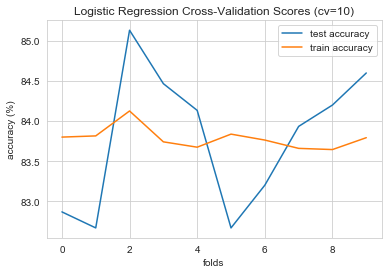

Linear SVC Mean Cross-Validation score: 83.15%


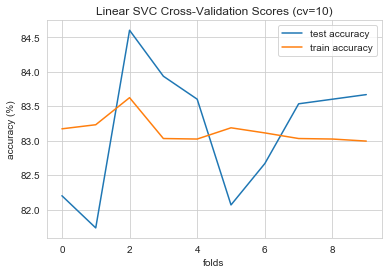

Nearest Centroid Mean Cross-Validation score: 82.40%


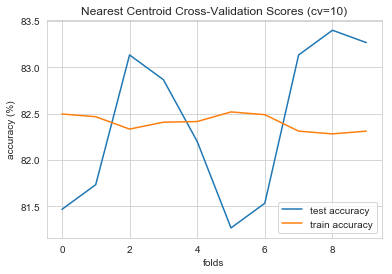

In [43]:
# evaluating models with some visualizations
mean_scores = {}
for name, pipe in pipes.items():
    mean_score = model_fit_cv_score(pipe, X_train, y_train, 10, name)
    mean_scores[name] = mean_score

The performance graphs above indeed show that the models appear to be under-fitted with test accuracy performing above train. Therefore, while these models work for establishing a baseline we are keeping in mind that they show quite a lot of room for model performance improvement via feature engineering and parameter tuning.

## Task 3 Feature Engineering

Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

In [44]:
try:
    df3 = load_from_cache('./cache/task1.pkl', 'task1')
    
    # rebuild our column lists if we load from cache
    obj_msk = (df3.dtypes == object)
    cat_msk = (df3.dtypes == 'category')
    cont_msk = (df3.dtypes == 'float64') | (df3.dtypes == 'int64')
    objects = obj_msk[obj_msk].index.tolist()
    categoricals = cat_msk[cat_msk].index.tolist()
    continuous = list(set(cont_msk[cont_msk].index.tolist()) - set(['Payment_for_Research']))
except FileNotFoundError as e:
    print(e)
    df3 = df

Loading task1 data from cache...
Took 3.49 seconds to load task1 data


### Derived Features

Again we subsample the data, both for convenience and as an initial way to deal with the imbalanced classes

In [45]:
pos_class = df3[df3['Payment_for_Research'] == 1].sample(n=10000, random_state=42)
neg_class = df3[df3['Payment_for_Research'] == 0].sample(n=10000, random_state=42)
df3 = pd.concat([pos_class, neg_class])

In [46]:
df3.shape

(20000, 18)

This time, we first extract new features from the text fields and only drop them afterwards.  First we extract months and days from the `Date_of_Payment` field (year is homogenous and therefore irrelevant) and then we extract latitude and longitude by constructing address from the `Recipient_*` fields.

In [47]:
df3[objects].nunique()

Recipient_Primary_Business_Street_Address_Line1    13041
Recipient_Primary_Business_Street_Address_Line2     2181
Date_of_Payment                                      358
dtype: int64

In [48]:
pmt_datetime = datetime_lookup(df3['Date_of_Payment'])
df3['Month_of_Payment'] = pmt_datetime.dt.month.astype('category')
df3['Day_of_Payment'] = pmt_datetime.dt.day.astype('category')

In [49]:
# update list
categoricals = list(set(categoricals) | set(['Month_of_Payment', 'Day_of_Payment']))

In [50]:
# sanity check - should print True
set(df3.columns) == set(objects + categoricals + continuous + ['Payment_for_Research'])

True

Next, we decided to extract latitude and longitude from the recipient address to see if it could improve our model. **Note: This takes very long to run - you should probably skip this cell if running anything but a very small sample**

In [ ]:
# we seem to get better results when we omit address line 2 and city
#     + df3['Recipient_Primary_Business_Street_Address_Line2'].astype(object) + ', ' \
addresses = df3['Recipient_Primary_Business_Street_Address_Line1'].astype(object) + ', ' \
    + df3['Recipient_City'].astype(object) + ', ' \
    + df3['Recipient_State'].astype(object) + ' ' \
    + df3['Recipient_Zip_Code'].astype(object)

coord_df = geocoords(addresses)
df3 = pd.concat([df3, coord_df], axis=1)

# update list
continuous = list(set(continuous) | set(['Recipient_Latitude', 'Recipient_Longitude']))

Only now do we again drop the object/text fields before proceeding

In [51]:
df3.drop(columns=objects, inplace=True)

In [52]:
# sanity check - should print True
set(df3.columns) == set(categoricals + continuous + ['Payment_for_Research'])

True

### Categorical Variables


This time, rather than dropping categorical features with more than 10 categories, we will target encode them.

In [53]:
X = df3.drop(columns=['Payment_for_Research'])
y = df3['Payment_for_Research']

In [54]:
save_to_cache('./cache/task3.pkl', 'task3', X)
#X = load_from_cache('./cache/task3.pkl', 'task3')

Caching task3 data...
Took 0.02 seconds to cache task3


In [55]:
target_msk = (X[categoricals].nunique() > 10)
ohe_msk = ~target_msk

target_cols = target_msk[target_msk].index.tolist()
ohe_cols = ohe_msk[ohe_msk].index.tolist()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [57]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

The TargetEncoder was not playing nice with the Pipeline so we do this operation beforehand.

In [58]:
te = TargetEncoder(cols=target_cols, handle_unknown='ignore')

In [59]:
X_train = te.fit_transform(X_train, y_train)

In [60]:
X_test = te.transform(X_test)

### More Preprocessing

We also add PolynomialFeatures and try PowerTransformer rather than StandardScaler. We found that PolynomialFeatures may slightly improve the model, but PowerTransformer doesn't make much of a difference. We also tried adding the MissingIndicator but it made the performance much worse by ~5-10% for each of the three models.

In [61]:
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), 
                   StandardScaler(),
                   PolynomialFeatures(include_bias=False)), continuous),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), 
                   OneHotEncoder(handle_unknown='ignore')), ohe_cols),
    (make_pipeline(SimpleImputer(strategy='mean')), target_cols))

# note target_cols are numeric after target encoding so we are safe to use mean imputer for missing data

### Model Evaluation

We now would like to evaluate if the above feature engineering has improved our model performance.

In [70]:
new_pipes = {}
new_pipes['Logistic Regression'] = make_pipeline(preprocess, LogisticRegression(solver='liblinear'))
new_pipes['Linear SVC'] = make_pipeline(preprocess, LinearSVC(dual=False))
new_pipes['Nearest Centroid'] = make_pipeline(preprocess, NearestCentroid())

Logistic Regression Mean Cross-Validation score: 94.38%


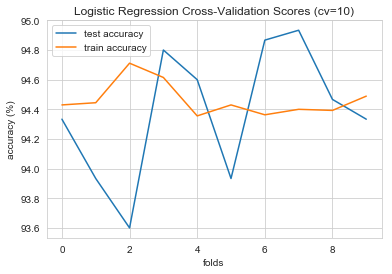

Linear SVC Mean Cross-Validation score: 94.13%


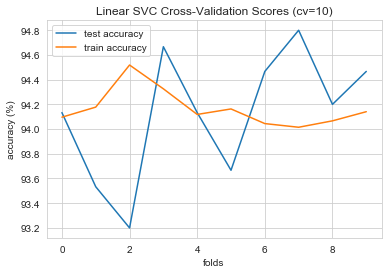

Nearest Centroid Mean Cross-Validation score: 62.04%


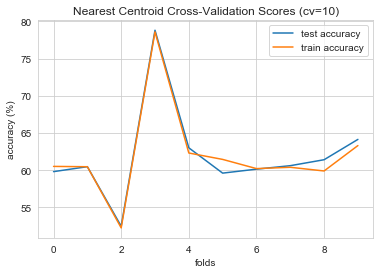

In [71]:
# evaluating models with some visualizations
new_scores = []
for name, pipe in new_pipes.items():
    score = model_fit_cv_score(pipe, X_train, y_train, 10, name)
    new_scores.append(score)

As we can see from the graphs above, the linear model score after more advanced preprocessing has indeed improved significantly above the baseline. Oddly enough, Nearest Neighbor classifier actually has suffered due to our preprocessing decisions. We will exclude that model for our final best model evaluation.

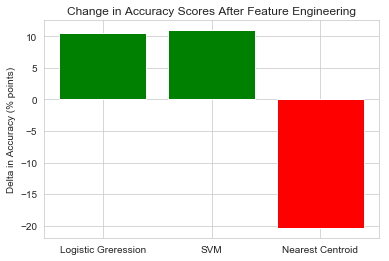

In [72]:
scores_delta = new_scores - np.fromiter(mean_scores.values(),  dtype=float)

# visualizing delta in cross-validation scores
colormat=np.where(scores_delta>0, 'g','r')
plt.bar(range(0,3),scores_delta*100, color=colormat)
plt.xticks(np.arange(3), ['Logistic Greression', 'SVM', 'Nearest Centroid'])
plt.ylabel('Delta in Accuracy (% points)')
plt.title('Change in Accuracy Scores After Feature Engineering')
plt.show()

## Task 4 Any model

Use any classification model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate.

In [76]:
best_pipes = {}
best_pipes['Logistic Regression'] = make_pipeline(preprocess, LogisticRegression(solver='liblinear'))
best_pipes['Linear SVC'] = make_pipeline(preprocess, LinearSVC())
best_pipes['Random Forest'] = make_pipeline(preprocess, RandomForestClassifier(n_estimators=100, max_depth=10))
best_pipes['Gradient Boosting'] = make_pipeline(preprocess, XGBClassifier())

Logistic Regression Mean Cross-Validation score: 94.38%


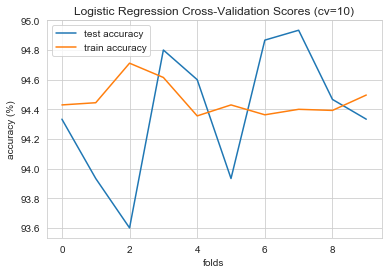

Linear SVC Mean Cross-Validation score: 94.43%


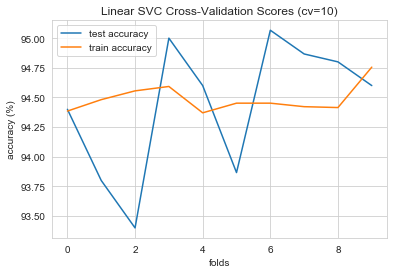

Random Forest Mean Cross-Validation score: 97.03%


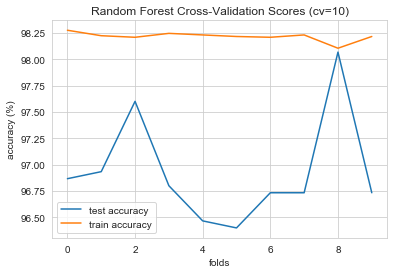

Gradient Boosting Mean Cross-Validation score: 96.88%


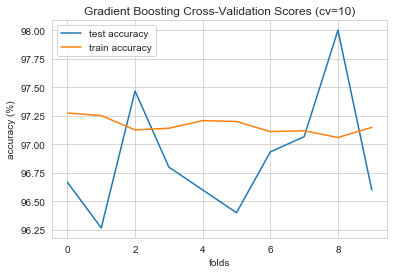

In [77]:
best_scores = {}
for name, pipe in best_pipes.items():
    best_score = model_fit_cv_score(pipe, X_train, y_train, 10, name)
    best_scores[name] = best_score

While the LogisticRegression and LinearSVC give us a nice reference point on how much our feature engineering improved the model, the Random Forest and Gradient Boosting models appear to be more robust and give our best overall scores.

### Hyperparameter Optimization

Now let's see if we can do better with a bit of hyperparamter optimization

In [78]:
logistic_params = {
    'logisticregression__C': np.logspace(-3, 3, 13)
}

svm_params = {
    'linearsvc__C': np.logspace(-3, 3, 13)
}

rf_params = {
    'randomforestclassifier__max_depth': [2, 4, 6], 
    'randomforestclassifier__n_estimators': [50, 100, 200]
}

xgb_params = {
    'xgbclassifier__max_depth': [2, 4, 6], 
    'xgbclassifier__n_estimators': [50, 100, 200]
}

In [83]:
logistic_grid = GridSearchCV(best_pipes['Logistic Regression'], logistic_params, cv=10, return_train_score=True)
logistic_grid.fit(X_train, y_train)
print(logistic_grid.best_params_)
print(logistic_grid.best_score_)

{'logisticregression__C': 3.1622776601683795}
0.9442


In [84]:
svm_grid = GridSearchCV(best_pipes['Linear SVC'], svm_params, cv=10, return_train_score=True, n_jobs=-1)
svm_grid.fit(X_train, y_train)
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'linearsvc__C': 10.0}
0.9466666666666667


In [85]:
rf_grid = GridSearchCV(best_pipes['Random Forest'], rf_params, cv=10, return_train_score=True, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 200}
0.9652


In [86]:
xgb_grid = GridSearchCV(best_pipes['Gradient Boosting'], xgb_params, cv=10, return_train_score=True, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

{'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 200}
0.9717333333333333


It looks like the cross validation did not do much for both Logistic Regression and Linear SVC, improves slightly for and Gradient Boosting, but decreases a bit for Random Forest.

### Generalization

In [87]:
log_eval = logistic_grid.score(X_test, y_test)
svm_eval = svm_grid.score(X_test, y_test)
rf_eval = rf_grid.score(X_test, y_test)
xgb_eval = xgb_grid.score(X_test, y_test)
print(f'Logistic Regression {log_eval}')
print(f'Linear SVC {svm_eval}')
print(f'Random Forest: {rf_eval}')
print(f'Gradient Boosting: {xgb_eval}')

Logistic Regression 0.9264
Linear SVC 0.9344
Random Forest: 0.9586
Gradient Boosting: 0.9524


It appears the Random Forest Classifier is the best model overall when evaluating on the hidden test set, with Gradient Boosting a close second.

## Task 5 Feature Selections

Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

### Feature Importance

To better identify features that are important for our best model, we first assess feature importance.  This is more straightforward for the Linear SVC than for the Random Forest and Gradient Boosting classifiers, since we have easy access to coefficients for the SVM model.

In [89]:
lin_svc = svm_grid.best_estimator_.named_steps['linearsvc']
svm_coefficients = lin_svc.coef_.flatten().tolist()

col_trans = svm_grid.best_estimator_.named_steps['columntransformer']

svm_poly = col_trans.transformers_[0][1].steps[2][1].get_feature_names()
svm_poly = [x.replace('x0', continuous[0]) for x in svm_poly] # rename appropriately
svm_ohe = col_trans.transformers_[1][1].steps[1][1].get_feature_names().tolist()
svm_ohe = [ohe_cols[int(x[1])] + x[2:] for x in svm_ohe] # rename appropriately

svm_feature_names = svm_poly + svm_ohe + target_cols
print(len(svm_feature_names) == len(svm_coefficients))

svm_feature_importance = dict(zip(svm_feature_names, svm_coefficients))

True


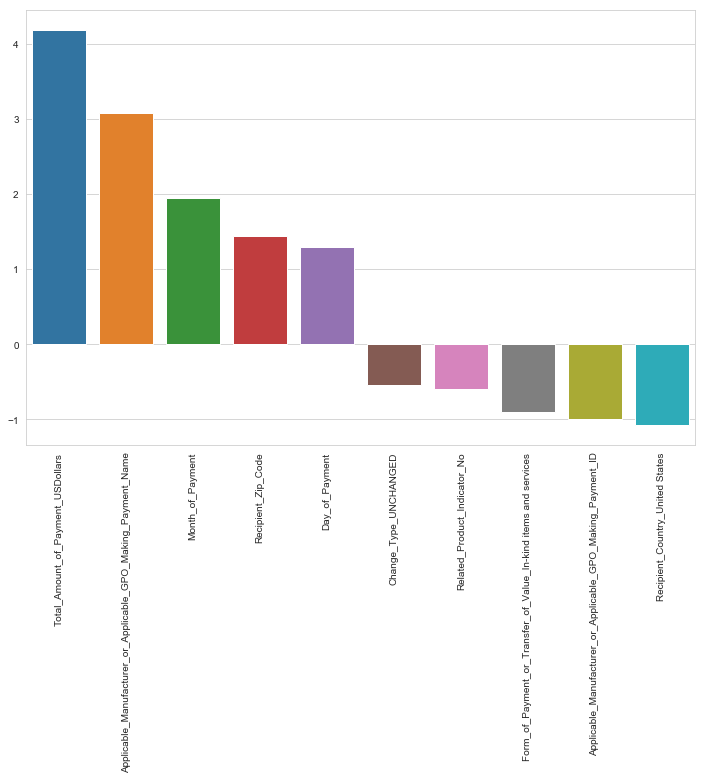

In [90]:
svm_top_scores = sorted(svm_feature_importance, 
                        key=svm_feature_importance.get, 
                        reverse=True)

svm_x = []
svm_y = []
# top five positive and top five negative features
for col in svm_top_scores[:5] + svm_top_scores[-5:]:
    svm_x.append(col)
    svm_y.append(svm_feature_importance[col])

plt.figure(figsize=(12, 8))
sns.barplot(x=svm_x, y=svm_y)
plt.xticks(rotation=90)
plt.show()

We see that our one continuous feature, `Total_Amount_of_Payment_USDollars`, is the strongest signal, followed by the other positive signals `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name`, `Month_of_Payment`, `Recipient_Zip_Code`, and `Day_of_Payment`.  Interestingly, two of these five feature (day and month of payment) were features that we engineered from other data. And the second strongest signal was one that we dropped in our baseline model due to high cardinality, but kept and target encoded for our improved model.

In [91]:
svm_feature_importance

{'Total_Amount_of_Payment_USDollars': 4.187060337858919,
 'Total_Amount_of_Payment_USDollars^2': -0.062337545071792504,
 'Recipient_Country_Canada': 0.0,
 'Recipient_Country_Great Britain (Uk)': 0.1070106669866498,
 'Recipient_Country_United States': -1.0753485465865142,
 'Change_Type_CHANGED': -0.4819820891871611,
 'Change_Type_NEW': 0.053840777755674,
 'Change_Type_UNCHANGED': -0.5401965681683116,
 'Form_of_Payment_or_Transfer_of_Value_Cash or cash equivalent': -0.06476925567843203,
 'Form_of_Payment_or_Transfer_of_Value_In-kind items and services': -0.9035686239213415,
 'Related_Product_Indicator_No': -0.5905053063817038,
 'Related_Product_Indicator_Yes': -0.3778325732181282,
 'Dispute_Status_for_Publication_No': -0.5169213326566273,
 'Dispute_Status_for_Publication_Yes': -0.4514165469431798,
 'Recipient_State': -0.02064865434881935,
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name': 3.075194792580753,
 'Recipient_City': 0.33845844463881486,
 'Applicable_Manufacturer_

Otherwise, it looks like the polynomimal feature for payment amount does not do much. And a few of the recipient countries are not very important. One form of payment also does not look very significant, not the recipient state. It is interesting that for the one hot encoded features, one category may sometimes be important while others are not. To further investigate feature importance and identify the features we may not need, let's iteratively build a model for each feature and see what the scores look like. 

In [92]:
mean_scores = {}
pipe1 = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), LinearSVC())
for col in continuous:
    X_train_sub = pd.DataFrame(X_train[col])
    scores = cross_val_score(pipe1, X_train_sub, y_train, cv=5)
    mean_scores[col] = np.mean(scores)

In [93]:
pipe2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'), LinearSVC())
for col in ohe_cols:
    X_train_sub = pd.DataFrame(X_train[col])
    scores = cross_val_score(pipe2, X_train_sub, y_train, cv=5)
    mean_scores[col] = np.mean(scores)

In [94]:
pipe3 = make_pipeline(SimpleImputer(strategy='mean'), LinearSVC())
for col in target_cols:
    X_train_sub = pd.DataFrame(X_train[col])
    scores = cross_val_score(pipe3, X_train_sub, y_train, cv=5)
    mean_scores[col] = np.mean(scores)

In [95]:
for name, score in mean_scores.items():
    print(f'{name}: {score:%}')

Total_Amount_of_Payment_USDollars: 58.193333%
Recipient_Country: 50.033333%
Change_Type: 51.493333%
Form_of_Payment_or_Transfer_of_Value: 82.293333%
Related_Product_Indicator: 54.226667%
Dispute_Status_for_Publication: 49.986667%
Recipient_State: 57.273333%
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name: 85.873333%
Recipient_City: 72.380000%
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID: 82.006667%
Day_of_Payment: 56.546667%
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State: 61.240000%
Recipient_Zip_Code: 79.286667%
Month_of_Payment: 53.266667%
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country: 54.833333%
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name: 76.640000%


It looks like these produced the weakest models and we may want to try dropping them from our best model:
* `Change_Type`
* `Dispute_Status_for_Publication`
* `Related_Product_Indicator`
* `Recipient_Country`
* `Month_of_Payment`

Some of these fields, like `Month_of_Payment` are giving mixed signals because just above we saw that they have some of the stronger coefficients in our main model.

Let us proceed dropping those fields to see how it would affect model performance.

In [96]:
X_train_feature_test = X_train.drop(['Change_Type', 'Dispute_Status_for_Publication', 'Recipient_Country', 
                                     'Related_Product_Indicator'], axis=1)
X_test_feature_test = X_test.drop(['Change_Type', 'Dispute_Status_for_Publication', 'Recipient_Country', 
                                     'Related_Product_Indicator'], axis=1)
ohe_cols_new = []
ohe_cols_new.append(ohe_cols[2])

In [97]:
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), 
                   StandardScaler(),
                   PolynomialFeatures(include_bias=False)), continuous),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), 
                   OneHotEncoder(handle_unknown='ignore')), ohe_cols_new),
    (make_pipeline(SimpleImputer(strategy='mean')), target_cols))

model = make_pipeline(preprocess, 
                      LinearSVC(C=10)) #choosing best performing parameter

In [98]:
model.fit(X_train_feature_test, y_train)
print("Accuracy of Linear SVC After Feature Removal:", 
      np.round(model.score(X_test_feature_test, y_test)*100), "%")

Accuracy of Linear SVC After Feature Removal: 93.0 %


Removing irrelevant features did not hurt the model performance too much, as expected. Nonetheless, it did not make the model better either.

Lastly, we can also look into the feature importance of the RandomForest model (since it is best performing)

In [99]:
model = make_pipeline(preprocess, 
                      RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=-1))

In [100]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mea..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [ ]:
# we can also look at the individual summed feature importances
importances = model.steps[1][1].feature_importances_
std = np.std([model.steps[1][1].feature_importances_ for tree in model.steps[1][1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

sorted_features = []
for ind in indices:
    sorted_features.append(svm_feature_names[ind])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(svm_feature_names)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(len(svm_feature_names)), sorted_features)
plt.ylim([-1, len(svm_feature_names)])
plt.show()

We can see how right away the two top feature importances between the two models (Random Forest and SVM) are aligned (which is probably a good sign). Nonetheless, it does look like certain features are rather irrelevant if we were to believe this measure. Therefore, let us remove them from the dataset and see if random forest performs any better (we will be using the same shortened dataset as for the Linear SVC).

In [102]:
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), 
                   StandardScaler(),
                   PolynomialFeatures(include_bias=False)), continuous),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), 
                   OneHotEncoder(handle_unknown='ignore')), ohe_cols_new),
    (make_pipeline(SimpleImputer(strategy='mean')), target_cols))

model = make_pipeline(preprocess, 
                      RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=-1))

In [103]:
model.fit(X_train_feature_test, y_train)
print("Accuracy of Random Forest After Feature Removal:", 
      np.round(model.score(X_test_feature_test, y_test)*100), "%")

Accuracy of Random Forest After Feature Removal: 96.0 %


It looks like removing those features does not seem to significantly hurt our model.

## Task 6 An explainable model

Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a small number of leafs etc.

We will attempt working with two very small models like Rndom forest with only three estimators and a very small Logistic Regression. Looking at their coefficients as well as tree visualization will help us makew the models very explainable.

In [105]:
preprocess.fit(X_train_feature_test)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(...plicable_GPO_Making_Payment_Country', 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'])])

In [106]:
# getting feature names from the new dataset (with irrelevant features dropped)
new_poly = preprocess.transformers_[0][1].steps[2][1].get_feature_names()
new_poly = [x.replace('x0', continuous[0]) for x in new_poly] # rename appropriately
new_ohe = preprocess.transformers_[1][1].steps[1][1].get_feature_names().tolist()
new_ohe = [ohe_cols_new[int(x[1])] + x[2:] for x in new_ohe] # rename appropriately

new_feature_names = new_poly + new_ohe + target_cols

In [107]:
model = make_pipeline(preprocess, 
                      RandomForestClassifier(max_depth = 5, max_leaf_nodes = 5, n_estimators=3))
model.fit(X_train_feature_test, y_train)
# Extract every tree
estimator1 = model.steps[1][1].estimators_[0]
estimator2 = model.steps[1][1].estimators_[1]
estimator3 = model.steps[1][1].estimators_[2]
# Export as dot file
export_graphviz(estimator1, out_file='tree1.dot', 
                feature_names = new_feature_names,
                class_names = ['general', 'research'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
export_graphviz(estimator2, out_file='tree2.dot', 
                feature_names = new_feature_names,
                class_names = ['general', 'research'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
export_graphviz(estimator3, out_file='tree3.dot', 
                feature_names = new_feature_names,
                class_names = ['general', 'research'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

Here is a nice representation of our small random forest model with only three trees involved. Each of them is a small tree that is possible to explore.

In [108]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree1.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [109]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree2.dot', '-o', 'tree2.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree2.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [110]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree3.dot', '-o', 'tree3.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree3.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

But the question still holds. How does our small model perform on the test set? Let us check and see:

In [111]:
# evaluating tree accuracy on the test set
print("Final Hidden Test Model Performance:", np.round(model.score(X_test_feature_test, y_test)*100, 1), "%")

Final Hidden Test Model Performance: 88.7 %


Wow! It actually looks like a small model is not too far off from the more complex original Random Forest with 100 predictors! This could be explained by the fact that some of the features capture our target very well (high correlation that we might have missed).

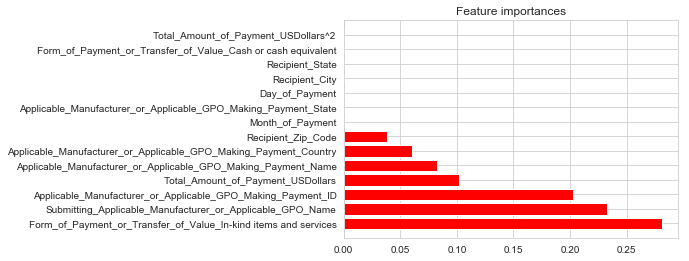

In [112]:
# we can also look at the individual summed feature importances
importances = model.steps[1][1].feature_importances_
std = np.std([model.steps[1][1].feature_importances_ for tree in model.steps[1][1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

sorted_features = []
for ind in indices:
    sorted_features.append(new_feature_names[ind])
    
# plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(new_feature_names)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(len(new_feature_names)), sorted_features)
plt.ylim([-1, len(new_feature_names)])
plt.show()

We can see that we could have made the model even simpler, dropping some of the features in the list.

Let us now play around with logistic regression as an alternative option for a simple and interpretable model. Given feature importances from the task 5, we can only select a handful of them to then explore the resulting coefficients.

In [113]:
important_features = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
                     'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
                     'Total_Amount_of_Payment_USDollars', 'Recipient_Zip_Code']

# creating a subset
X_train_simple_sub = X_train[important_features]
X_test_simple_sub = X_test[important_features]

In [114]:
target_cols_new = []
for feature in important_features:
    target_cols_new.append(feature)

In [115]:
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), 
                   StandardScaler(),
                   PolynomialFeatures(include_bias=False)), continuous),
    (make_pipeline(SimpleImputer(strategy='mean')), target_cols_new))

In [116]:
model = make_pipeline(preprocess, LogisticRegression(dual=False))
model.fit(X_train_simple_sub, y_train)
# Extract coefficients
coefficients = model.steps[1][1].coef_
# evaluating accuracy on the test set
print("Final Hidden Test Model Performance:", np.round(model.score(X_test_simple_sub, y_test)*100, 1), "%")

Final Hidden Test Model Performance: 90.0 %


In [117]:
preprocess.fit(X_train_simple_sub)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(...e_Manufacturer_or_Applicable_GPO_Name', 'Total_Amount_of_Payment_USDollars', 'Recipient_Zip_Code'])])

In [118]:
# getting feature names from the new dataset (with irrelevant features dropped)
new_poly = preprocess.transformers_[0][1].steps[2][1].get_feature_names()
new_poly = [x.replace('x0', continuous[0]) for x in new_poly] # rename appropriately

new_feature_names = new_poly + target_cols_new

In [119]:
coefficients_df = pd.DataFrame(index=range(0,6))
coefficients_df['value'] = coefficients[0].astype('float64')
coefficients_df['feature_name'] = new_feature_names

In [120]:
coefficients_df

,value,feature_name
0,0.223966,Total_Amount_of_Payment_USDollars
1,-0.221268,Total_Amount_of_Payment_USDollars^2
2,2.298773,Applicable_Manufacturer_or_Applicable_GPO_Maki...
3,1.107008,Submitting_Applicable_Manufacturer_or_Applicab...
4,0.000379,Total_Amount_of_Payment_USDollars
5,0.905171,Recipient_Zip_Code


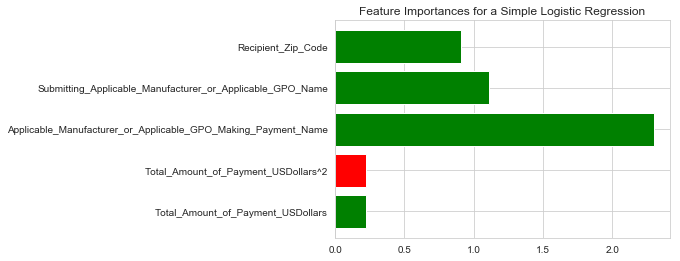

In [121]:
colormat=np.where(coefficients[0]>0, 'g','r')
plt.barh(new_feature_names, abs(coefficients[0]), color=colormat)
plt.title('Feature Importances for a Simple Logistic Regression')
plt.show()

GPO payment name appears to be a very important indicator across all models. Hypothetically, there could be a domain explaination of why it might be skewing positively the total accuracy (potential information leakage we would not know about). Nonetheless, for now we have decided to keep it in our final models and assume that it is just a very predictive feature.